In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing
import warnings
warnings.filterwarnings("ignore")

In [50]:
colspecs = [(2, 10), (10, 22), (56, 69), (82, 95)]
names = ['Data', 'Codigo', 'Preco_Abertura', 'Preco_Fechamento']

# Leitura dos dados
df_2024 = pd.read_fwf('COTAHIST_A2024.TXT', colspecs=colspecs, names=names, header=None)

# Filtragem para conter somente o ano de 2024
AMAZON_df = df_2024[df_2024['Codigo'].str.endswith('AMZO34')].copy()
AMAZON_df['Data'] = pd.to_datetime(AMAZON_df['Data'], format='%Y%m%d')
AMAZON_df['Ano'] = AMAZON_df['Data'].dt.year
AMAZON_df['Mes'] = AMAZON_df['Data'].dt.month
AMAZON_df['Dia'] = AMAZON_df['Data'].dt.day
AMAZON_df.set_index('Data', inplace=True)
AMAZON_df.sort_index(inplace=True)

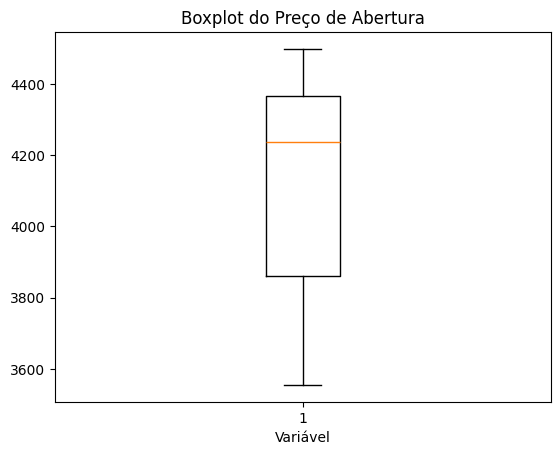

In [51]:
plt.boxplot(AMAZON_df['Preco_Abertura'])
plt.title('Boxplot do Preço de Abertura')
plt.xlabel('Variável')
plt.show()


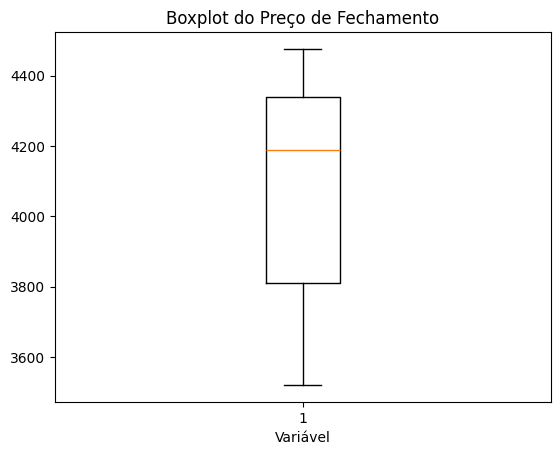

In [52]:
plt.boxplot(AMAZON_df['Preco_Fechamento'])
plt.title('Boxplot do Preço de Fechamento')
plt.xlabel('Variável')
plt.show()

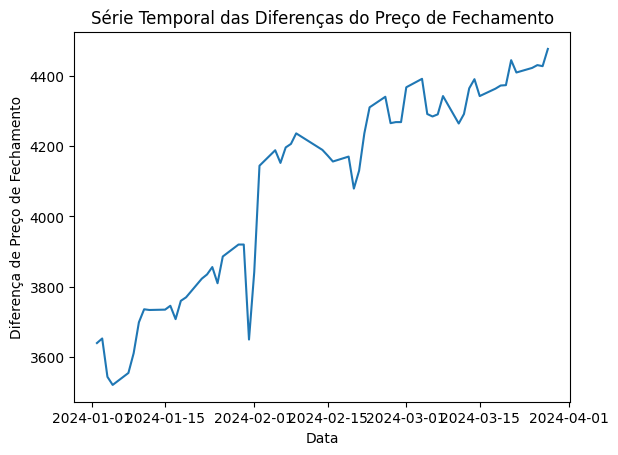

In [53]:
result = seasonal_decompose(AMAZON_df['Preco_Fechamento'], model='additive', period=30)

# Visualização da série temporal das diferenças do preço de fechamento
AMAZON_df['Diferenca'] = AMAZON_df['Preco_Fechamento']
plt.plot(AMAZON_df['Diferenca'])
plt.title('Série Temporal das Diferenças do Preço de Fechamento')
plt.xlabel('Data')
plt.ylabel('Diferença de Preço de Fechamento')
plt.show()

In [54]:
# Suavização exponencial
alpha = 0.1  # Fator de suavização
model_exp = SimpleExpSmoothing(AMAZON_df['Preco_Fechamento']).fit(smoothing_level=alpha)
AMAZON_df['Suavizacao_EXP'] = model_exp.fittedvalues

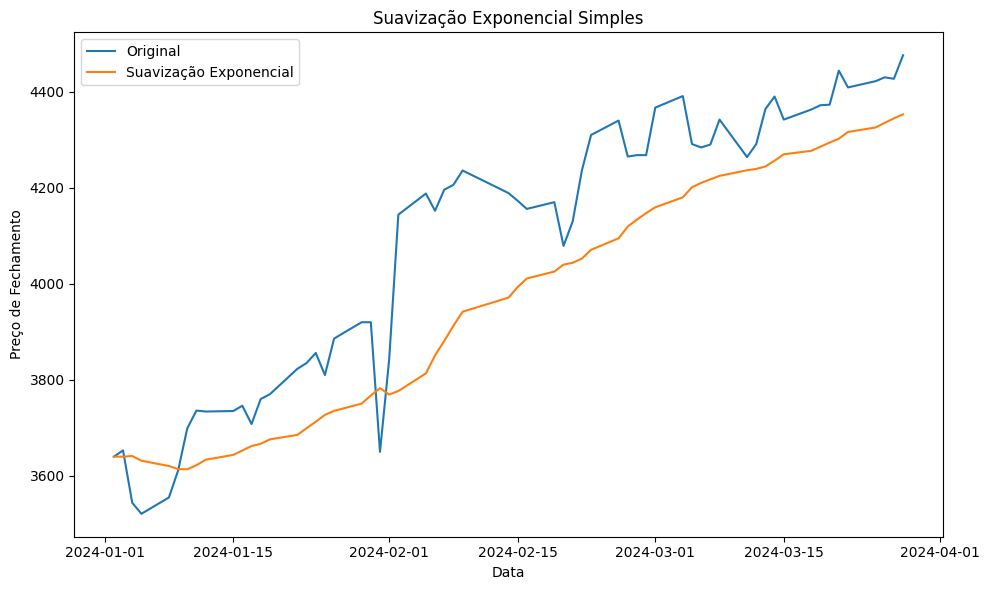

In [55]:
# Plotando a suavização exponencial
plt.figure(figsize=(10, 6))
plt.plot(AMAZON_df.index, AMAZON_df['Preco_Fechamento'], label='Original')
plt.plot(AMAZON_df.index, AMAZON_df['Suavizacao_EXP'], label='Suavização Exponencial')
plt.title('Suavização Exponencial Simples')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.tight_layout()
plt.show()

In [56]:

# Ajuste do modelo ARIMA nos dados suavizados
resultado_teste = adfuller(AMAZON_df['Suavizacao_EXP'].dropna())
print('Estatística do teste:', resultado_teste[0])
print('Valor-p:', resultado_teste[1])

Estatística do teste: -0.6370414683791026
Valor-p: 0.8623906201388045


In [57]:


modelo_arima = auto_arima(AMAZON_df['Preco_Fechamento'], seasonal=False, suppress_warnings=True)

# Previsões
horizonte = 10
previsoes_finais = modelo_arima.predict(n_periods=horizonte)


In [58]:
previsoes_df = pd.DataFrame(previsoes_finais, columns=['Previsao'])

# Convertendo o índice para o formato de data
previsoes_df.index = pd.date_range(start=AMAZON_df.index[-1] + pd.Timedelta(days=1), periods=len(previsoes_df), freq='D')

# Convertendo para uma representação em string
texto_previsoes = previsoes_df.to_string()

print(texto_previsoes)

               Previsao
2024-03-29  4512.172859
2024-03-30  4527.132436
2024-03-31  4535.340726
2024-04-01  4550.507092
2024-04-02  4565.673458
2024-04-03  4580.839824
2024-04-04  4596.006190
2024-04-05  4611.172556
2024-04-06  4626.338922
2024-04-07  4641.505288


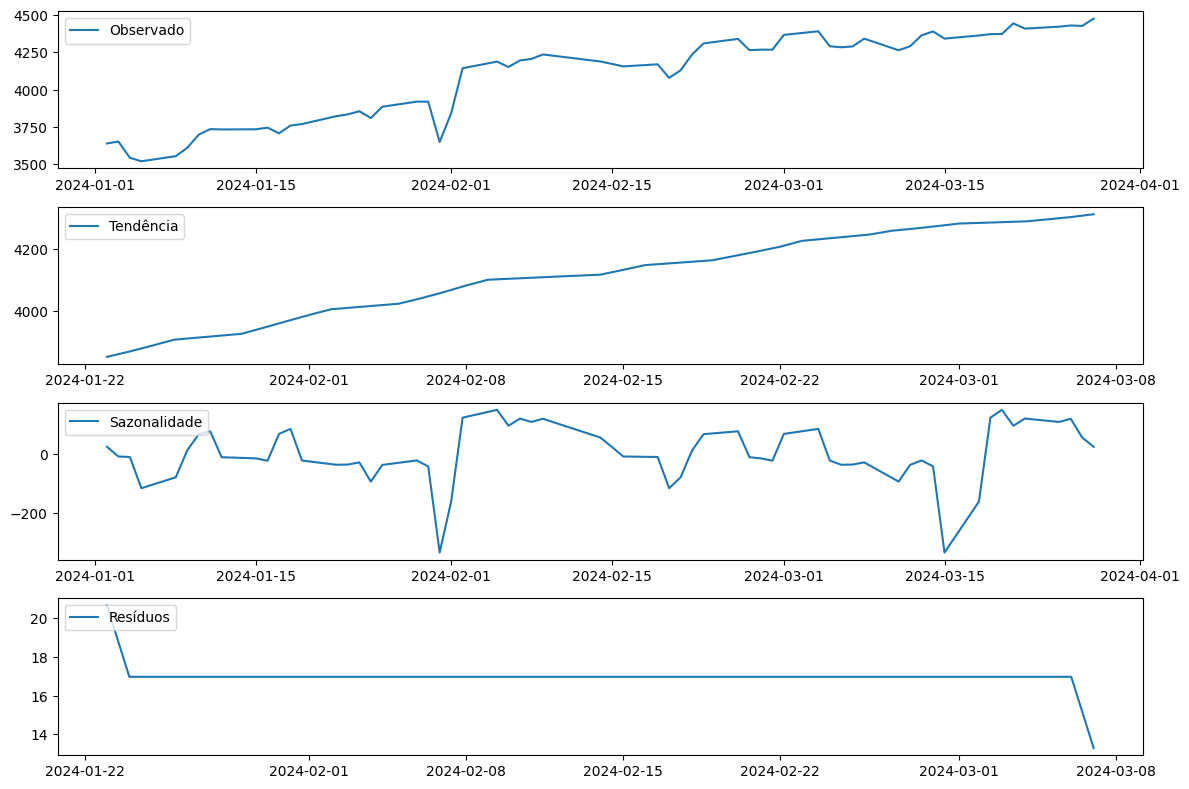

In [59]:
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(result.observed, label='Observado')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend, label='Tendência')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal, label='Sazonalidade')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid, label='Resíduos')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

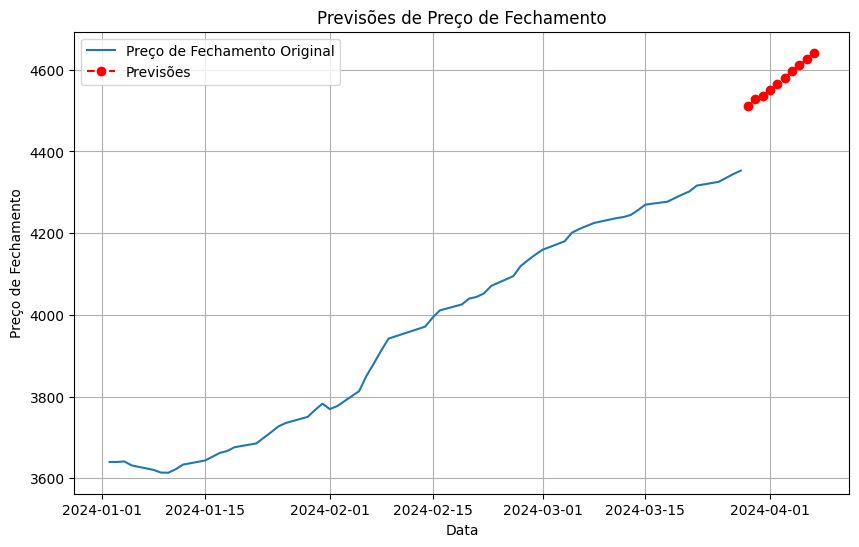

In [60]:

plt.figure(figsize=(10, 6))
plt.plot(AMAZON_df.index, AMAZON_df['Suavizacao_EXP'], label='Preço de Fechamento Original')
plt.plot(previsoes_df.index, previsoes_df['Previsao'], marker='o', linestyle='--', color='red', label='Previsões')
plt.title('Previsões de Preço de Fechamento')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()